In [1]:
import os
import cv2
import shutil
import numpy as np
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Path Setup
RAW_PATH = '/content/drive/MyDrive/RESEARCH_PAPER/Raw_Videos'
BASE_DATASET = '/content/dataset_temp'
FINAL_DATASET = '/content/dataset_final'

# Clear old directories to start fresh
for path in [BASE_DATASET, FINAL_DATASET]:
    if os.path.exists(path): shutil.rmtree(path)

def extract_frames(subfolder, label, frames_per_video=80):
    input_dir = os.path.join(RAW_PATH, subfolder)
    output_dir = os.path.join(BASE_DATASET, label)
    os.makedirs(output_dir, exist_ok=True)

    videos = [f for f in os.listdir(input_dir) if f.lower().endswith(('.mp4', '.mov', '.avi'))]
    print(f"🎬 Processing {label}: {len(videos)} videos found.")

    for v_name in videos:
        cap = cv2.VideoCapture(os.path.join(input_dir, v_name))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        if total_frames <= 0: continue

        interval = max(1, total_frames // frames_per_video)
        saved, count = 0, 0
        while saved < frames_per_video:
            ret, frame = cap.read()
            if not ret: break
            if count % interval == 0:

                frame = cv2.resize(frame, (224, 224))
                cv2.imwrite(os.path.join(output_dir, f"{v_name}_f{saved}.jpg"), frame)
                saved += 1
            count += 1
        cap.release()


extract_frames('Real', 'real', frames_per_video=80)
extract_frames('AI', 'ai', frames_per_video=80)

Mounted at /content/drive
🎬 Processing real: 60 videos found.
🎬 Processing ai: 67 videos found.


In [2]:
train_dir = os.path.join(FINAL_DATASET, 'train')
val_dir = os.path.join(FINAL_DATASET, 'val')

for cl in ['real', 'ai']:
    os.makedirs(os.path.join(train_dir, cl), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cl), exist_ok=True)

    all_frames = os.listdir(os.path.join(BASE_DATASET, cl))
    video_names = list(set([f.split('_f')[0] for f in all_frames]))

    np.random.shuffle(video_names)
    split = int(0.8 * len(video_names))

    train_vids = video_names[:split]

    for f in all_frames:
        v_name = f.split('_f')[0]
        src = os.path.join(BASE_DATASET, cl, f)
        dest_folder = train_dir if v_name in train_vids else val_dir
        shutil.copy(src, os.path.join(dest_folder, cl, f))

print("✅ Data splitting complete based on video identity!")

✅ Data splitting complete based on video identity!


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision


policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)


train_gen = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=64, class_mode='binary')
val_gen = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=64, class_mode='binary', shuffle=False)

Found 9108 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.7),
    layers.Dense(1, activation='sigmoid', dtype='float32') # Final layer must be float32 for mixed precision
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='binary_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [7]:
checkpoint_path = "/content/drive/MyDrive/RESEARCH_PAPER/cp.weights.h5"


if os.path.exists(checkpoint_path + ".index"):
    print("♻️  Loading existing checkpoint... Resuming training.")
    model.load_weights(checkpoint_path)
else:
    print("🆕 No checkpoint found. Starting fresh training.")


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True, verbose=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)


class_weights = {0: 1.0, 1: 1.5} # AI vs Real

print("🚀 Efficient Training Started...")
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    class_weight=class_weights,
    callbacks=[cp_callback, early_stop]
)

model.save('/content/drive/MyDrive/RESEARCH_PAPER/south_asian_reels_final.keras')
print("✅ Best Research Model Saved!")

🆕 No checkpoint found. Starting fresh training.
🚀 Efficient Training Started...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.6371 - loss: 1.5174 
Epoch 1: saving model to /content/drive/MyDrive/RESEARCH_PAPER/cp.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 3332s 23s/step - accuracy: 0.6374 - loss: 1.5164 - val_accuracy: 0.4962 - val_loss: 1.1388
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7129 - loss: 1.1161 
Epoch 2: saving model to /content/drive/MyDrive/RESEARCH_PAPER/cp.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 3299s 23s/step - accuracy: 0.7129 - loss: 1.1157 - val_accuracy: 0.7231 - val_loss: 0.9318
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7339 - loss: 0.9403 
Epoch 3: saving model to /content/drive/MyDrive/RESEARCH_PAPER/cp.weights.h5
143/143 ━━━━━━━━━━━━━━━━━━━━ 3342s 23s/step - accuracy: 0.7339 - loss: 0.9401 - val_accuracy: 0.7529 - val_loss: 0.8198
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 21s/step - accuracy: 0.7517 - loss: 0.8562 
Epoch 4: saving model to /content/drive/MyDrive/RESEARCH_PAPE

17/17 ━━━━━━━━━━━━━━━━━━━━ 342s 20s/step

📊 Final Research Evaluation Report:
              precision    recall  f1-score   support

          AI       0.90      0.55      0.68       480
        Real       0.71      0.95      0.81       560

    accuracy                           0.76      1040
   macro avg       0.80      0.75      0.75      1040
weighted avg       0.80      0.76      0.75      1040



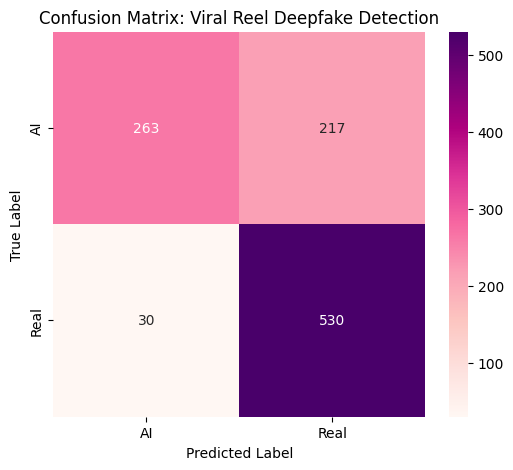

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

val_gen.reset()
preds = model.predict(val_gen)
y_pred = (preds > 0.5).astype(int).flatten()
y_true = val_gen.classes

print("\n📊 Final Research Evaluation Report:")
print(classification_report(y_true, y_pred, target_names=['AI', 'Real']))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='RdPu', xticklabels=['AI', 'Real'], yticklabels=['AI', 'Real'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: Viral Reel Deepfake Detection')
plt.show()

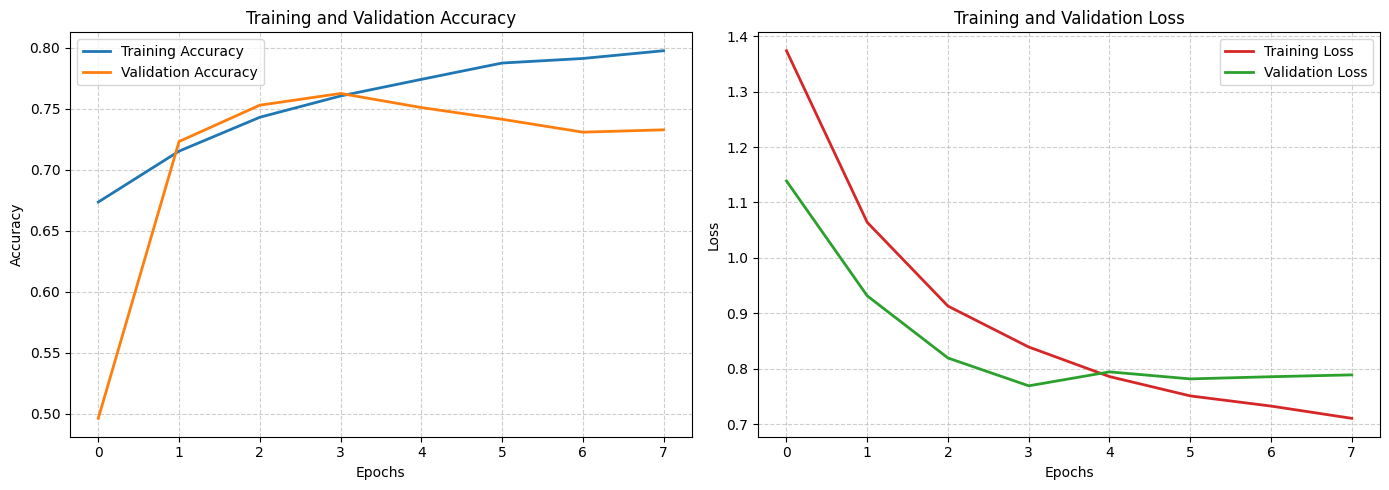

In [10]:
import matplotlib.pyplot as plt


plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#1f77b4', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#ff7f0e', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# লস গ্রাফ
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#d62728', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#2ca02c', linewidth=2)
plt.title('Training and Validation Loss', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/RESEARCH_PAPER/training_performance.png')
plt.show()